In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import re


### Импорт и анализ данных

In [2]:
# cannot use pd.read_csv directly due to commas in text column 
def get_data(filename="filename.txt"): 
    records = [] 
    with open(filename, "r") as file: 
        data_lines = file.readlines() 
        for line in data_lines: 
            parts = line.split(",", 1) 
            if parts[0].strip() == "id": 
                continue 
            line_num = int(parts[0].strip()) 
            text = parts[1].strip() if len(parts) > 1 else "" 
            records.append({'id': line_num, 'text_no_spaces': text}) 
        return pd.DataFrame(records) 
    
data_df = get_data("filename.txt") 
data_df

,id,text_no_spaces
0,0,куплюайфон14про
1,1,ищудомвПодмосковье
2,2,сдаюквартирусмебельюитехникой
3,3,новыйдивандоставканедорого
4,4,отдамдаромкошку
...,...,...
1000,1000,Янеусну.
1001,1001,Весна-яуженегреюпио.
1002,1002,Весна-скоровырастеттрава.
1003,1003,"Весна-выпосмотрите,каккрасиво."


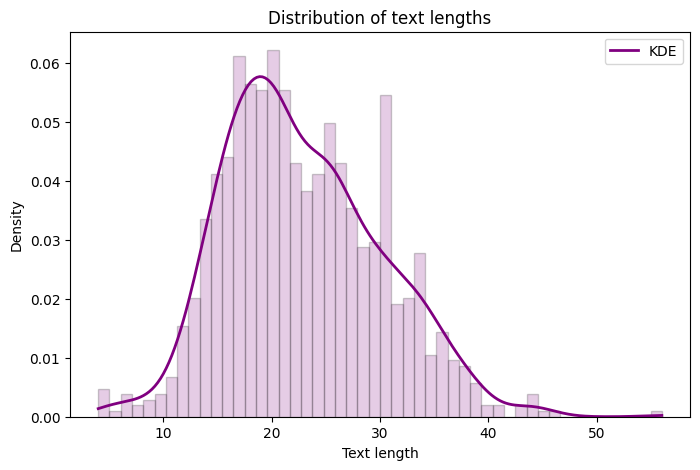

In [3]:
# text length analysis
data_df['text_length'] = data_df['text_no_spaces'].apply(len)

# kde
length_values = data_df['text_length'].values
kde = gaussian_kde(length_values)
x_range = np.linspace(length_values.min(), length_values.max(), 200)
kde_vals = kde(x_range)


plt.figure(figsize=(8,5))
plt.hist(length_values, bins=50, density=True, alpha=0.2, color="purple", edgecolor="black")
plt.plot(x_range, kde_vals, color="purple", linewidth=2, label="KDE")
plt.title("Distribution of text lengths")
plt.xlabel("Text length")
plt.ylabel("Density")
plt.legend()
plt.show()


In [4]:
# analyze punctuation
punctuation_re = re.compile(r"[.,!?;:()\-\"]")

data_df["has_punctuation"] = data_df["text_no_spaces"].str.contains(punctuation_re)
num_with_punctuation = data_df["has_punctuation"].sum()
total_num_of_texts = data_df.shape[0]

print(f'Number of texts with punctuation: {num_with_punctuation}')
print(f'Total number of texts: {total_num_of_texts}')
print(f'Percentage of texts with punctuation: {num_with_punctuation/total_num_of_texts}')

Number of texts with punctuation: 447
Total number of texts: 1005
Percentage of texts with punctuation: 0.44477611940298506


In [5]:
# check for language
import pandas as pd

def check_language(text):
    russian_language = sum('А' <= ch <= 'я' or ch in 'Ёё' for ch in text)
    english_language = sum('A' <= ch <= 'Z' or 'a' <= ch <= 'z' for ch in text)
    if russian_language > english_language:
        return "Russian"
    elif english_language > russian_language:
        return "English"


data_df['language'] = data_df['text_no_spaces'].apply(check_language)
data_df['language'].value_counts()


language
Russian    995
English      9
Name: count, dtype: int64

I decided to use [wordfreq](https://pypi.org/project/wordfreq/) python library that has word frequencies

In [6]:
!pip3 install wordfreq


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


### Идея решения

Проходимся по тексту и делим его на пунктуацию, цифры и слова. Для разбиения слов используем подход динамического программирования: выбираем разделение, которое дает минимальный скор. Скор слова зависит от логарифма частоты его встречаемости, а ткже включает в себя пенальти за 1 букву, за длину слова (чтобы оно не было слишком большим) и за слишком малую частоту втсречаемости. Скор слова уменьшается, если слово начинается с заглавной буквы. После такого разбиения решаем, где нужно поставить пробелы по правилам русского языка.

In [7]:
from wordfreq import word_frequency

minimum_freq = 1e-12
low_freq_penalty = 20.0
one_char_penalty = 3.0
uppercase_bonus = 0.55
max_word_length = 20
length_penalty = 0.8

def get_token_score(given_token):
    lower_token = given_token.lower()
    freq = word_frequency(lower_token, "ru", minimum=minimum_freq)
    score = -np.log(freq)
    if freq <= minimum_freq + 1e-12:
        # addd penalty for low frequency words
        score += low_freq_penalty + length_penalty * len(lower_token)
    if len(lower_token) == 1:
        score += one_char_penalty
    if lower_token[0].isupper() and len(lower_token) > 1:
        score -= uppercase_bonus
    return score

# dynamic programming
def segment_letters_block(text: str):
    n = len(text)
    if n == 0:
        return []
    best_cost = [np.inf] * (n + 1)
    backtrack = [-1] * (n + 1)
    best_cost[0] = 0.0

    for i in range(1, n + 1):
        best_local_cost = np.inf
        best_local_k = -1
        start = max(0, i - max_word_length)
        for k in range(start, i):
            # candidate for being separate word
            candidate = text[k:i]
            cost = best_cost[k] + get_token_score(candidate)
            if cost < best_local_cost:
                best_local_cost = cost
                best_local_k = k
        best_cost[i] = best_local_cost
        backtrack[i] = best_local_k

    # backtrack to get words
    words = []
    idx = n
    while idx > 0:
        split = backtrack[idx]
        if split < 0:
            split = idx - 1 
        words.append((text[split:idx], split, idx))
        idx = split
    words.reverse()
    return words

# split text into types: letter, digit or punctuation
def split_into_parts(text: str):
    parts = []
    i = 0
    text_length = len(text)
    while i < text_length:
        ch = text[i]
        if punctuation_re.match(ch):
            parts.append((ch, i, "punctuation"))
            i += 1
        elif ch.isdigit():
            j = i + 1
            while j < text_length and text[j].isdigit():
                j += 1
            parts.append((text[i:j], i, "digit"))
            i = j
        else:
            j = i + 1
            while j < text_length and (not punctuation_re.match(text[j])) and (not text[j].isdigit()):
                j += 1
            parts.append((text[i:j], i, "letters"))
            i = j
    return parts

def is_space_needed(left_token, right_token):
    if left_token["kind"] == "punctuation":
        if left_token["text"] in {"-", "–", "/"}:
            return False
        # if left is punctuation (except "-", "–", "/"), space needed before word or digit
        return right_token["kind"] in {"word", "digit"}
    # before punctuation no space is needed
    if right_token["kind"] == "punctuation":
        return False
    return True

# main function to extract separate words and spaces positions
def extract_words_and_spaces(text):
    tokens = []
    # split text into parts with types: letter, digit or punctuation
    for block_text, offset, kind in split_into_parts(text):
        # extract words with start and end indices
        if kind == "letters":
            for w, s, e in segment_letters_block(block_text):
                tokens.append({"text": w, "start": offset + s, "end": offset + e, "kind": "word"})
        # extract digits
        elif kind == "digit":
            tokens.append({"text": block_text, "start": offset, "end": offset + len(block_text), "kind": "digit"})
        # extract punctuation marks
        else:
            tokens.append({"text": block_text, "start": offset, "end": offset + 1, "kind": "punctuation"})

    # get the final result
    out_chunks = []
    space_positions = []
    for i, tok in enumerate(tokens):
        if i > 0:
            prev = tokens[i - 1]
            if is_space_needed(prev, tok):
                # пробел вставлен ПОСЛЕ символа с индексом prev["end"] - 1
                space_positions.append(prev["end"] - 1)
                out_chunks.append(" ")
        out_chunks.append(tok["text"])
    return "".join(out_chunks), space_positions



In [8]:
result = []
extract_words_and_spaces(data_df['text_no_spaces'][0])
for idx, row in data_df.iterrows():
    restored_text, space_positions = extract_words_and_spaces(row['text_no_spaces'])
    cur_id = row['id']
    cur_predicted_positions = space_positions
    cur_result = {
        'id': cur_id,
        'predicted_positions': cur_predicted_positions,
        'original_text': restored_text
    }
    result.append(cur_result)
result_df = pd.DataFrame(result)
result_df

,id,predicted_positions,original_text
0,0,"[4, 9, 11]",куплю айфон 14 про
1,1,"[2, 5, 6]",ищу дом в Подмосковье
2,2,"[3, 11, 12, 19, 20]",сдаю квартиру с мебелью и техникой
3,3,"[4, 9, 17]",новый диван доставка недорого
4,4,"[4, 9]",отдам даром кошку
...,...,...,...
1000,1000,"[0, 2]",Я не усну.
1001,1001,"[6, 9, 11, 15]",Весна-я уже не грею пио.
1002,1002,"[10, 18]",Весна-скоро вырастет трава.
1003,1003,"[7, 18, 21]","Весна-вы посмотрите, как красиво."


In [9]:
# save result
result_df.to_csv("submission.csv", index=False)